In [1]:
# In this notebooke I'll merge the data from the different sources and save it to a pkl file

import pandas as pd
import numpy as np
import os
# from tqdm.notebook import trange, tqdm
import tqdm
import math
from multiprocessing import Pool

# stop warnings
pd.options.mode.chained_assignment = None  # default='warn'

DISTANCE_FROM_SCREEN = 62.0 #Distance between eyes and screen in cm
SCREEN_RESULUTION_WIDTH, SCREEN_RESULUTION_HEIGHT = 1920, 1080 #screen width and height in pixels (resulution)
SCREEN_WIDTH, SCREEN_HEIGHT = 59.8, 33.6 #screen width and height in cm

In [2]:
def isfloat(value):
  try:
    float(value)
    return True
  except ValueError:
    return False
  
def truncate(value) -> float:
  digits = 0
  # Improve accuracy with floating point operations, to avoid truncate(16.4, 2) = 16.39 or truncate(-1.13, 2) = -1.12
  nbDecimals = len(str(value).split('.')[1]) 
  if nbDecimals <= digits:
      return value
  stepper = 10.0 ** digits
  return math.trunc(stepper * value) / stepper

In [3]:
folder_path_webdata = '/srv/share/intent_prediction2024/processed_labels'  # Replace with the path to your folder
folder_path_eyetracking = '/srv/share/intent_prediction2024/eyetracking'  # Replace with the path to your folder

file_list_webdata = []
for root, dirs, files in os.walk(folder_path_webdata):
    for file in files:
        file_path = os.path.join(root, file)
        file_list_webdata.append(file_path)
print(file_list_webdata)

file_list_eyetracking = []
for root, dirs, files in os.walk(folder_path_eyetracking):
    for file in files:
        file_path = os.path.join(root, file)
        file_list_eyetracking.append(file_path)
print(file_list_eyetracking)

pids = sorted([int(f.split('/')[-1].split('.')[0]) for f in file_list_eyetracking])
print(len(pids))
pids

['/srv/share/intent_prediction2024/processed_labels/webdata_22.pkl', '/srv/share/intent_prediction2024/processed_labels/webdata_27.pkl', '/srv/share/intent_prediction2024/processed_labels/webdata_17.pkl', '/srv/share/intent_prediction2024/processed_labels/webdata_6.pkl', '/srv/share/intent_prediction2024/processed_labels/webdata_14.pkl', '/srv/share/intent_prediction2024/processed_labels/webdata_21.pkl', '/srv/share/intent_prediction2024/processed_labels/webdata_10.pkl', '/srv/share/intent_prediction2024/processed_labels/webdata_26.pkl', '/srv/share/intent_prediction2024/processed_labels/webdata_19.pkl', '/srv/share/intent_prediction2024/processed_labels/webdata_24.pkl', '/srv/share/intent_prediction2024/processed_labels/webdata_42.pkl', '/srv/share/intent_prediction2024/processed_labels/webdata_3.pkl', '/srv/share/intent_prediction2024/processed_labels/webdata_37.pkl', '/srv/share/intent_prediction2024/processed_labels/webdata_18.pkl', '/srv/share/intent_prediction2024/processed_label

[2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 13,
 14,
 15,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 30,
 31,
 33,
 34,
 35,
 36,
 37,
 38,
 40,
 41,
 42,
 44,
 45]

In [4]:
def extract_eyetracking(pid):
    '''
    This function extracts eye tracking data from a file for a given participant ID (pid).

    The function reads a file from a specific path, which is constructed using the provided pid. 
    The file is expected to contain lines of data, each line representing a different type of data 
    (time data, mouse data, message data, or gaze data).

    The function iterates over each line in the file. If a line contains one of the predefined keywords 
    ('UNIX:', 'Pointer', 'MSG'), it is added to the corresponding list (time_data, mouse_data, messages_data). 
    If a line does not contain any of these keywords, the function checks if the first element of the line 
    is a float and if the line has a length of 9. If both conditions are met, the line is added to the gaze_data list.

    Parameters:
    pid (str): The participant ID, used to construct the file path.

    Returns:
    tuple: A tuple containing four lists - gaze_data, time_data, mouse_data, messages_data.
    '''
        
    # Define the path to the file
    ET_path = f'/srv/share/intent_prediction2024/eyetracking/{pid}.asc'

    # Initialize lists to store data
    messages_data = []
    gaze_data = []
    time_data = []
    mouse_data = []

    # Define a dictionary to map conditions to lists
    conditions = {
        'UNIX:': time_data,
        'Pointer': mouse_data, # 'Pointer' is the keyword for mouse data in the eye tracking files
        'MSG': messages_data
    }

    # Open the file and over each line
    with open(ET_path) as f:
        for line in f:
            line = line.split()
            if line:
                # Check if line matches any of the conditions
                for condition, data_list in conditions.items():
                    if condition in line:
                        data_list.append(line)
                        break
                    # If line does not match any condition, check if it's a float and has length 9 (binocular gaze data) or 6 (monocular gaze data)
                if isfloat(line[0]) and (len(line) == 9 or len(line) == 6):
                    gaze_data.append(line[:-1])

    return gaze_data, time_data, mouse_data, messages_data

In [5]:
def preprocess(pid):
    print(pid)
    webdata_path = f'/srv/share/intent_prediction2024/processed_labels/webdata_{pid}.pkl'

    df_web = pd.read_pickle(webdata_path)
    gaze_data, time_data, mouse_data, messages_data = extract_eyetracking(pid)

    df_eye = None

    if len(gaze_data[0]) == 8:
        df_eye = pd.DataFrame(gaze_data, columns=['Time', 'X_L', 'Y_L', 'PupilSize_L', 'X_R', 'Y_R', 'PupilSize_R', 'ParticipantNr'])
        del df_eye['X_L']
        del df_eye['Y_L']
        del df_eye['PupilSize_L']
        
        df_eye.columns = ['Time', 'X', 'Y', 'PupilSize', 'ParticipantNr']
    elif len(gaze_data[0]) == 5:
        df_eye = pd.DataFrame(gaze_data, columns=['Time', 'X', 'Y', 'PupilSize', 'ParticipantNr'])

    df_time = pd.DataFrame(time_data, columns=['Message', 'ETT', 'MSG2', 'UnixTimeStamp'])

    # Replace all '.' with np.nan in df_eye and cast to float
    df_eye = df_eye.replace('.', np.nan).astype(float)

    # add helper column for merging the time data
    df_eye['Time_diff'] = df_eye['Time'].diff()
    df_time[['ETT', 'UnixTimeStamp']] = df_time[['ETT', 'UnixTimeStamp']].astype(float)
    df_time['UnixTimeStamp'] = df_time['UnixTimeStamp'] * 1000 # Convert to milliseconds to match the eye tracking data

    merged_df = df_eye.merge(df_time, left_on='Time', right_on='ETT', how='left')
    merged_df['UnixTimeStamp'] = merged_df['UnixTimeStamp'].astype(float)

    del merged_df['Message']
    del merged_df['MSG2']
    del merged_df['ETT']
    del merged_df['ParticipantNr']
    
    # Find the index of the first non-null value in UnixTimeStamp
    first_non_null_index = merged_df['UnixTimeStamp'].first_valid_index()

    # Fill NaN values in UnixTimeStamp by adding or subtracting values from Time_diff
    merged_df['UnixTimeStamp'] = merged_df['UnixTimeStamp'].fillna(
        merged_df['UnixTimeStamp'].iloc[first_non_null_index] + np.cumsum(merged_df['Time_diff'])
    )

    '''
    Mouse data
    1. Lines with mouse data have brackets and comma's, we get rid of them and replace them with nothing
    2. Do this is a single loop to optimize the code
    3. Create a pandas DataFrame with the filtered data
    '''
    # Initialize lists to store filtered data
    filtered_mouse_data_time = []
    filtered_mouse_data_x = []
    filtered_mouse_data_y = []

    # Loop over mouse_data once and perform all operations
    for m in mouse_data:
        filtered_mouse_data_time.append(m[1])
        filtered_mouse_data_x.append(float(m[-2].replace('(', '').replace(',', '')))
        filtered_mouse_data_y.append(float(m[-1].replace(')', '')))

    print(merged_df.size)

    # Create a pandas DataFrame
    df_mouse_filtered = pd.DataFrame({
        'Time': filtered_mouse_data_time,
        'X_mouse': filtered_mouse_data_x,
        'Y_mouse': filtered_mouse_data_y
    }, dtype=float)

    merged_df_mouse = merged_df.merge(df_mouse_filtered, on='Time', how='left')
    messages_data_filtered = [m for m in messages_data if 'Chrome' in m]
    filtered_list = [[item[1], item[-1]] for item in messages_data_filtered]

    replacement_dict = {
        "Home": "SmartHome",
        "Pot": "CookingPot",
        "Chair": "OfficeChair",
        "Weights": "DumbellWeights",
        "Machine": "CoffeeMachine",
        "Toothbrush": "ElectricToothbrush",
        "Keyboard": "PianoKeyboard"
    }

    filtered_list = [[item[0], replacement_dict.get(item[-1], item[-1])] for item in filtered_list]
    trial_df = pd.DataFrame(filtered_list, columns=['Time', 'Item'])
    trial_df['Time'] = trial_df['Time'].astype(float)

    # Create a copy of the dataframe, decrement the time by 1 and append it to the original dataframe
    # We want to do this because of the logging of the eye tracking data being at 500 Hz and not 1000 Hz
    df_copy = trial_df.copy()
    df_copy['Time'] -= 1
    trial_df = pd.concat([trial_df, df_copy], ignore_index=False)

    merged_dfX = pd.merge(merged_df_mouse, trial_df, on='Time', how='left')
    merged_dfX['Item'] = merged_dfX['Item'].ffill()
    merged_dfX.dropna(subset=['Item'], inplace=True)

    # Calculate the time difference between the first eye tracking data and the first click
    time_diff = df_web[df_web['CurrentEvent'] == 'load'].iloc[0].CurrentTimstamp - merged_dfX[merged_dfX['Item'].notnull()].iloc[0].UnixTimeStamp
    merged_dfX['UnixTimeStamp'] += time_diff

    df_click = df_web[df_web['CurrentEvent'] == 'click']
    df_click['Timestampdiff'] = df_click['CurrentTimstamp'].diff()

    # Check if the CurrentURL stays the same, to identify multiple clicks on the same page due to lagg from recording
    df_click['SameURL'] = df_click['CurrentURL'] == df_click['CurrentURL'].shift()#
    df_click['SameTarget'] = df_click['CurrentTarget'] == df_click['CurrentTarget'].shift()

    # Filter out clicks that are too close to each other (2 seconds) and on the same URL and target
    df_click_filtered = df_click[~((df_click.Timestampdiff <= 2000) & (df_click['SameURL']) & (df_click['SameTarget']))]

    # truncating the two timestamps to make them match
    df_click_filtered['CurrentTimstamp'] = (df_click_filtered['CurrentTimstamp'].astype(float)).apply(truncate)
    merged_dfX['UnixTimeStamp'] = (merged_dfX['UnixTimeStamp'].astype(float)).apply(truncate)

    # Create a copy of the dataframe, decrement the time by 1 and append it to the original dataframe
    # We want to do this because of the logging of the eye tracking data being at 500 Hz and not 1000 Hz
    df_copy = df_click_filtered.copy()
    df_copy['CurrentTimstamp'] -= 1
    df_click_filtered = pd.concat([df_click_filtered, df_copy], ignore_index=False)

    # merging the click data with the eye tracking data
    merged_df2 = pd.merge(merged_dfX, df_click_filtered[['CurrentTimstamp', 'CurrentClickX', 'CurrentClickY', 'CurrentURL']], 
                     left_on='UnixTimeStamp', right_on='CurrentTimstamp', how='left')

    # Delete helper columns
    del merged_df2['Time']
    del merged_df2['Time_diff']
    del merged_df2['CurrentTimstamp']

    # Reorder columns
    merged_df2 = merged_df2[['UnixTimeStamp', 'X', 'Y', 'PupilSize', 'X_mouse', 'Y_mouse', 'Item', 'CurrentClickX', 'CurrentClickY', 'CurrentURL']]

    merged_df2[['X', 'Y', 'X_mouse', 'Y_mouse', 'CurrentClickX', 'CurrentClickY']] = merged_df2[['X', 'Y', 'X_mouse', 'Y_mouse', 'CurrentClickX', 'CurrentClickY']].astype(np.float16)
    merged_df2['UnixTimeStamp'] = merged_df2['UnixTimeStamp'].astype(np.float64)

    merged_df2.to_pickle(os.getcwd() + f'/PML/S2024/IntentPrediction_LSTM/Data/{pid}.pkl')

    # TODO: Interpolation of the eye tracking data
    



In [18]:
for pid in pids:
    preprocess(pid)

2
5932506
3
6042072
4
6195624
5
6465624
6
6258048
7
6010848
8
6145014
9
6513354
10
6544980
11
6161682
13
6105606
14
6145014
15
6251358
17
6078384
18
6066018
19
6008568
20
5978040
21
5922426
22
6709290
23
6139962
24
6255018
25
6496074
26
6213672
27
5869872
30
6271656
31
5998398
33
6405162
34
6350064
35
6380814
36
6096504
37
5906136
38
6032970
40
5897142
41
6275922
42
6030966
44
5903532
45
6129888


In [28]:
folder_path = os.getcwd() + f'/Data/'  # Replace with the path to your folder

file_list = []
for root, dirs, files in os.walk(folder_path):
    for file in files:
        file_path = os.path.join(root, file)
        if not 'merged' in file_path:
            file_list.append(file_path)
print(file_list)

['/home/ru74xip/PML/S2024/IntentPrediction_LSTM/Data/21.pkl', '/home/ru74xip/PML/S2024/IntentPrediction_LSTM/Data/19.pkl', '/home/ru74xip/PML/S2024/IntentPrediction_LSTM/Data/36.pkl', '/home/ru74xip/PML/S2024/IntentPrediction_LSTM/Data/38.pkl', '/home/ru74xip/PML/S2024/IntentPrediction_LSTM/Data/9.pkl', '/home/ru74xip/PML/S2024/IntentPrediction_LSTM/Data/14.pkl', '/home/ru74xip/PML/S2024/IntentPrediction_LSTM/Data/22.pkl', '/home/ru74xip/PML/S2024/IntentPrediction_LSTM/Data/4.pkl', '/home/ru74xip/PML/S2024/IntentPrediction_LSTM/Data/8.pkl', '/home/ru74xip/PML/S2024/IntentPrediction_LSTM/Data/5.pkl', '/home/ru74xip/PML/S2024/IntentPrediction_LSTM/Data/25.pkl', '/home/ru74xip/PML/S2024/IntentPrediction_LSTM/Data/27.pkl', '/home/ru74xip/PML/S2024/IntentPrediction_LSTM/Data/13.pkl', '/home/ru74xip/PML/S2024/IntentPrediction_LSTM/Data/45.pkl', '/home/ru74xip/PML/S2024/IntentPrediction_LSTM/Data/17.pkl', '/home/ru74xip/PML/S2024/IntentPrediction_LSTM/Data/23.pkl', '/home/ru74xip/PML/S2024/In

In [33]:
dfs = []
for file in file_list:
    dfX = pd.read_pickle(file)
    dfX['pid'] = np.int8(file.split('/')[-1].split('.')[0])

    # Interpolate the eye tracking data to fill in gaps, as LSTM models cannot deal with missing data
    # Based on: https://doi.org/10.1145/3588015.3589202, https://doi.org/10.1145/3613904.3642086 and https://doi.org/10.1145/3649902.3656353
    dfX[['X', 'Y', 'PupilSize']] = dfX[['X', 'Y', 'PupilSize']].interpolate(method='linear')

    # > 96% of the data is missing, so we drop the mouse columns
    del dfX['X_mouse']
    del dfX['Y_mouse']
    dfs.append(dfX)

df = pd.concat(dfs, ignore_index=True)

In [34]:
df

,UnixTimeStamp,X,Y,PupilSize,Item,CurrentClickX,CurrentClickY,CurrentURL,pid
0,1.714461e+12,692.500000,662.500,1428.0,Sunscreen,NaN,NaN,NaN,21
1,1.714461e+12,690.000000,662.500,1428.0,Sunscreen,NaN,NaN,NaN,21
2,1.714461e+12,689.000000,667.000,1426.0,Sunscreen,NaN,NaN,NaN,21
3,1.714461e+12,690.500000,666.000,1425.0,Sunscreen,NaN,NaN,NaN,21
4,1.714461e+12,690.500000,666.000,1425.0,Sunscreen,NaN,NaN,NaN,21
...,...,...,...,...,...,...,...,...,...
37910621,1.714982e+12,22.203125,209.125,339.0,DumbellWeights,NaN,NaN,NaN,40
37910622,1.714982e+12,21.593750,209.250,338.0,DumbellWeights,NaN,NaN,NaN,40
37910623,1.714982e+12,21.296875,209.750,337.0,DumbellWeights,NaN,NaN,NaN,40
37910624,1.714982e+12,22.796875,209.000,337.0,DumbellWeights,NaN,NaN,NaN,40


In [35]:
df.to_pickle(os.getcwd() + f'/Data/merged_data.pkl')

In [32]:
dfX.X_mouse.isnull().sum() / dfX.shape[0]

0.9649540531603505

In [ ]:
ä

In [ ]:
merged_df2.head()

,UnixTimeStamp,X,Y,PupilSize,X_mouse,Y_mouse,Item,CurrentClickX,CurrentClickY,CurrentURL
0,1.713791e+12,933.2,451.6,1191.0,NaN,NaN,Screwdriver,NaN,NaN,NaN
1,1.713791e+12,933.6,451.8,1192.0,NaN,NaN,Screwdriver,NaN,NaN,NaN
2,1.713791e+12,934.3,451.6,1192.0,NaN,NaN,Screwdriver,NaN,NaN,NaN
3,1.713791e+12,932.4,451.1,1192.0,NaN,NaN,Screwdriver,NaN,NaN,NaN
4,1.713791e+12,930.7,451.3,1192.0,NaN,NaN,Screwdriver,NaN,NaN,NaN


In [ ]:
merged_df2[['X', 'Y', 'X_mouse', 'Y_mouse', 'CurrentClickX', 'CurrentClickY']] = merged_df2[['X', 'Y', 'X_mouse', 'Y_mouse', 'CurrentClickX', 'CurrentClickY']].astype(np.float16)
merged_df2['UnixTimeStamp'] = merged_df2['UnixTimeStamp'].astype(np.float64)

In [ ]:
merged_df2.head()

,UnixTimeStamp,X,Y,PupilSize,X_mouse,Y_mouse,Item,CurrentClickX,CurrentClickY,CurrentURL
0,1.713791e+12,933.0,451.50,1191.0,NaN,NaN,Screwdriver,NaN,NaN,nan
1,1.713791e+12,933.5,451.75,1192.0,NaN,NaN,Screwdriver,NaN,NaN,nan
2,1.713791e+12,934.5,451.50,1192.0,NaN,NaN,Screwdriver,NaN,NaN,nan
3,1.713791e+12,932.5,451.00,1192.0,NaN,NaN,Screwdriver,NaN,NaN,nan
4,1.713791e+12,930.5,451.25,1192.0,NaN,NaN,Screwdriver,NaN,NaN,nan


In [ ]:
merged_df2.to_pickle(os.getcwd() + '/PML/S2024/IntentPrediction/merged_data.pkl')

In [ ]:
merged_df2.head()

,UnixTimeStamp,X_L,Y_L,PupilSize_L,X_R,Y_R,PupilSize_R,X_mouse,Y_mouse,Item,CurrentClickX,CurrentClickY,CurrentURL
0,1.713791e+12,921.0,422.5,1101.0,933.2,451.6,1191.0,NaN,NaN,Screwdriver,NaN,NaN,NaN
1,1.713791e+12,920.6,422.6,1102.0,933.6,451.8,1192.0,NaN,NaN,Screwdriver,NaN,NaN,NaN
2,1.713791e+12,921.0,425.0,1103.0,934.3,451.6,1192.0,NaN,NaN,Screwdriver,NaN,NaN,NaN
3,1.713791e+12,920.1,424.7,1105.0,932.4,451.1,1192.0,NaN,NaN,Screwdriver,NaN,NaN,NaN
4,1.713791e+12,919.0,424.7,1105.0,930.7,451.3,1192.0,NaN,NaN,Screwdriver,NaN,NaN,NaN


In [ ]:
merged_df2[merged_df2['CurrentClickX'].notnull()].head()

,UnixTimeStamp,X_L,Y_L,PupilSize_L,X_R,Y_R,PupilSize_R,X_mouse,Y_mouse,Item,CurrentClickX,CurrentClickY,CurrentURL
11222,1.713791e+12,1766.5,500.7,482.0,1650.9,521.4,470.0,NaN,NaN,Screwdriver,1447.0,615.0,https://www.amazon.com/s?k=screwdriver&crid=38...
37422,1.713791e+12,1159.3,848.5,504.0,1026.8,890.7,468.0,NaN,NaN,Screwdriver,1076.0,375.0,https://www.amazon.com/s?k=screwdriver&crid=38...
64391,1.713791e+12,1086.6,881.0,563.0,982.9,908.2,525.0,1034.0,826.0,Screwdriver,1037.0,831.0,https://www.amazon.com/s?k=screwdriver&crid=38...
65044,1.713791e+12,236.7,41.9,484.0,120.4,40.7,434.0,NaN,NaN,Screwdriver,1010.0,826.0,https://www.amazon.com/s?k=screwdriver&crid=38...
95416,1.713791e+12,1050.5,592.9,511.0,925.3,655.3,480.0,NaN,NaN,Fan,1106.0,363.0,https://www.amazon.com/s?k=fan&crid=1BV8TZEBR8...


In [ ]:
merged_df2[merged_df2['CurrentURL'].notnull()].CurrentURL.unique()

array(['https://www.amazon.com/s?k=fan&crid=1BV8TZEBR8TSE&sprefix=fan%2Caps%2C170&ref=nb_sb_noss_1',
       'https://www.amazon.com/s?k=cooking+pot&crid=2VN6S6RFH36X1&sprefix=cooking+po%2Caps%2C173&ref=nb_sb_noss_2',
       'https://www.amazon.com/s?k=drone&crid=2QM4GH5RTE79C&sprefix=dron%2Caps%2C178&ref=nb_sb_noss_2',
       'https://www.amazon.com/s?k=coffee+machine&crid=11BWLCTHCUDJX&sprefix=coffee+machi%2Caps%2C176&ref=nb_sb_noss_2',
       'https://www.amazon.com/s?k=candles&crid=2MW244B4C0D5U&sprefix=candle%2Caps%2C168&ref=nb_sb_noss_2',
       'https://www.amazon.com/Chesapeake-Bay-Candle-Rejuvenate-Mediterranean/dp/B07NHH3VF2/ref=sr_1_35?crid=2MW244B4C0D5U&dib=eyJ2IjoiMSJ9.fg-FWKFamiTCjTVtwnXtye2a6fzMJkKe93OGE_x26CwqK4J7AA7iquj9v0ZKSvB257cjpdpnGfxE1LTNpoWRLC-h2LzSmtMmT39SmMqjVTlDk5E814uiMbmXOQUTiX96NPrmLZ6dxppOmesqg5hceKP3Ww0F-1AsApR_R100rT7OIDKUYhpayCNHj85rrTMBkdeX7rohfi0MFv5ag0fRDY6iPIksSCn3_CZCLXcQOZ5hPCSVmDj4U59AZ-44NlnCs6JyLEZjJx9MHJhbqxVj7xJQ0dRVUClwGAntwxsGvdQ.6h2io5OnDY

In [ ]:
merged_df2['Item'].unique()

array(['Screwdriver', 'Fan', 'CookingPot', 'Drone', 'CoffeeMachine',
       'ElectricToothbrush', 'Candles', 'DumbellWeights', 'Sunscreen',
       'Sneakers', 'SmartHome', 'OfficeChair', 'Sunglasses',
       'PianoKeyboard', 'Plants'], dtype=object)

In [ ]:
merged_df2.head()

,Time,X_L,Y_L,PupilSize_L,X_R,Y_R,PupilSize_R,Time_diff,UnixTimeStamp,X_mouse,Y_mouse,Item,CurrentTimstamp,CurrentClickX,CurrentClickY,CurrentURL
0,327755233.0,957.4,941.2,1406.0,798.7,1013.8,1183.0,2.0,1.713784e+12,NaN,NaN,Drone,NaN,NaN,NaN,NaN
1,327755235.0,959.8,939.4,1406.0,797.7,1014.3,1184.0,2.0,1.713785e+12,NaN,NaN,Drone,NaN,NaN,NaN,NaN
2,327755237.0,960.0,944.1,1407.0,797.8,1013.7,1184.0,2.0,1.713785e+12,NaN,NaN,Drone,NaN,NaN,NaN,NaN
3,327755239.0,958.0,944.7,1408.0,798.0,1013.0,1185.0,2.0,1.713785e+12,NaN,NaN,Drone,NaN,NaN,NaN,NaN
4,327755241.0,958.9,941.1,1406.0,798.2,1014.0,1184.0,2.0,1.713785e+12,NaN,NaN,Drone,NaN,NaN,NaN,NaN


In [ ]:
merged_df2[(merged_df2['CurrentClickX'].notnull()) & (merged_df2['Item'] == 'Sunlasses')]

,Time,X_L,Y_L,PupilSize_L,X_R,Y_R,PupilSize_R,Time_diff,UnixTimeStamp,X_mouse,Y_mouse,Item,CurrentTimstamp,CurrentClickX,CurrentClickY,CurrentURL


<Axes: >

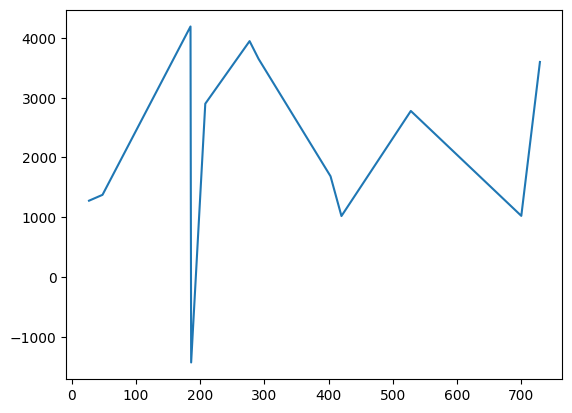

In [ ]:
df_click[df_click['Timestampdiff'] < 5000].Timestampdiff.plot()

In [ ]:
df_click[df_click['Timestampdiff'] < 0] 

,CurrentTimstamp,CurrentEvent,CurrentTarget,CurrentClickX,CurrentClickY,CurrentURL,outerWidth,outerHeight,innerWidth,innerHeight,created,CurrentHtml,Timestampdiff,SameURL,SameTarget
186,1713521826782,click,479480c0-856c-45a6-93cc-6c0cefca0813,1063.0,686.0,https://www.amazon.com/s?k=office+chair&crid=2...,1920.0,1040.0,1920.0,953.0,2024-04-19 10:17:10,"<body class=""a-m-us a-aui_72554-c a-aui_a11y_2...",-1431.0,False,False


In [ ]:
df_click[~((df_click.Timestampdiff <= 2000) & (df_click['SameURL']) & (df_click['SameTarget']))]

,CurrentTimstamp,CurrentEvent,CurrentTarget,CurrentClickX,CurrentClickY,CurrentURL,outerWidth,outerHeight,innerWidth,innerHeight,created,CurrentHtml,Timestampdiff,SameURL,SameTarget
22,1713521444697,click,d00d986a-0e39-4a0e-9914-3b618d3e6ece,1068.0,789.0,https://www.amazon.com/s?k=smart+home&crid=QXX...,1920.0,1040.0,1920.0,953.0,2024-04-19 10:10:45,"<body class=""a-m-us a-aui_72554-c a-aui_a11y_2...",NaN,False,False
26,1713521456862,click,606a6c76-f1e5-4bc0-bd39-f620de0c261b,460.0,639.0,https://www.amazon.com/s?k=smart+home&page=2&c...,1920.0,1040.0,1920.0,953.0,2024-04-19 10:10:58,"<body class=""a-m-us a-aui_72554-c a-aui_a11y_2...",12165.0,False,False
27,1713521458139,click,578c1ea2-ea5f-4634-b772-f8c464467692,450.0,632.0,https://www.amazon.com/s?k=smart+home&page=2&c...,1920.0,1040.0,1920.0,953.0,2024-04-19 10:11:00,"<body class=""a-m-us a-aui_72554-c a-aui_a11y_2...",1277.0,True,False
29,1713521468808,click,215c244b-bc2f-441f-b3b6-c3f35f5801fe,1327.0,690.0,https://www.amazon.com/s?k=smart+home&page=2&c...,1920.0,1040.0,1920.0,953.0,2024-04-19 10:11:10,"<body class=""a-m-us a-aui_72554-c a-aui_a11y_2...",10669.0,True,False
35,1713521486253,click,b4986f22-e54e-4038-a71e-791198032bcf,841.0,785.0,https://www.amazon.com/s?k=smart+home&page=2&c...,1920.0,1040.0,1920.0,953.0,2024-04-19 10:11:27,"<body class=""a-m-us a-aui_72554-c a-aui_a11y_2...",17445.0,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
729,1713524070400,click,0de967dd-d37a-46f0-bf7a-d2da2366aba0,794.0,672.0,https://www.amazon.com/s?k=drone&crid=2QM4GH5R...,1920.0,1040.0,1920.0,953.0,2024-04-19 10:54:32,"<body class=""a-m-us a-aui_72554-c a-aui_a11y_2...",3599.0,True,False
738,1713524104026,click,ad11ce20-8782-439f-9554-1954222253a2,508.0,294.0,https://www.amazon.com/s?k=drone&crid=2QM4GH5R...,1920.0,1040.0,1920.0,953.0,2024-04-19 10:55:06,"<body class=""a-m-us a-aui_72554-c a-aui_a11y_2...",33626.0,True,False
745,1713524124610,click,21c073f3-a5e8-4d77-92b6-8d7a4cdbb35d,1062.0,527.0,https://www.amazon.com/s?k=drone&crid=2QM4GH5R...,1920.0,1040.0,1920.0,953.0,2024-04-19 10:55:26,"<body class=""a-m-us a-aui_72554-c a-aui_a11y_2...",20584.0,True,False
755,1713524143246,click,ea87264d-11c6-4aa5-81c2-aea6f375add0,1637.0,632.0,https://www.amazon.com/s?k=drone&page=2&crid=2...,1920.0,1040.0,1920.0,953.0,2024-04-19 10:55:45,"<body class=""a-m-us a-aui_72554-c a-aui_a11y_2...",18636.0,False,False


In [ ]:
df_click_filtered

,CurrentTimstamp,CurrentEvent,CurrentTarget,CurrentClickX,CurrentClickY,CurrentURL,outerWidth,outerHeight,innerWidth,innerHeight,created,CurrentHtml,Timestampdiff,SameURL,SameTarget
22,1713521444697,click,d00d986a-0e39-4a0e-9914-3b618d3e6ece,1068.0,789.0,https://www.amazon.com/s?k=smart+home&crid=QXX...,1920.0,1040.0,1920.0,953.0,2024-04-19 10:10:45,"<body class=""a-m-us a-aui_72554-c a-aui_a11y_2...",NaN,False,False
26,1713521456862,click,606a6c76-f1e5-4bc0-bd39-f620de0c261b,460.0,639.0,https://www.amazon.com/s?k=smart+home&page=2&c...,1920.0,1040.0,1920.0,953.0,2024-04-19 10:10:58,"<body class=""a-m-us a-aui_72554-c a-aui_a11y_2...",12165.0,False,False
27,1713521458139,click,578c1ea2-ea5f-4634-b772-f8c464467692,450.0,632.0,https://www.amazon.com/s?k=smart+home&page=2&c...,1920.0,1040.0,1920.0,953.0,2024-04-19 10:11:00,"<body class=""a-m-us a-aui_72554-c a-aui_a11y_2...",1277.0,True,False
29,1713521468808,click,215c244b-bc2f-441f-b3b6-c3f35f5801fe,1327.0,690.0,https://www.amazon.com/s?k=smart+home&page=2&c...,1920.0,1040.0,1920.0,953.0,2024-04-19 10:11:10,"<body class=""a-m-us a-aui_72554-c a-aui_a11y_2...",10669.0,True,False
35,1713521486253,click,b4986f22-e54e-4038-a71e-791198032bcf,841.0,785.0,https://www.amazon.com/s?k=smart+home&page=2&c...,1920.0,1040.0,1920.0,953.0,2024-04-19 10:11:27,"<body class=""a-m-us a-aui_72554-c a-aui_a11y_2...",17445.0,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
729,1713524070400,click,0de967dd-d37a-46f0-bf7a-d2da2366aba0,794.0,672.0,https://www.amazon.com/s?k=drone&crid=2QM4GH5R...,1920.0,1040.0,1920.0,953.0,2024-04-19 10:54:32,"<body class=""a-m-us a-aui_72554-c a-aui_a11y_2...",3599.0,True,False
738,1713524104026,click,ad11ce20-8782-439f-9554-1954222253a2,508.0,294.0,https://www.amazon.com/s?k=drone&crid=2QM4GH5R...,1920.0,1040.0,1920.0,953.0,2024-04-19 10:55:06,"<body class=""a-m-us a-aui_72554-c a-aui_a11y_2...",33626.0,True,False
745,1713524124610,click,21c073f3-a5e8-4d77-92b6-8d7a4cdbb35d,1062.0,527.0,https://www.amazon.com/s?k=drone&crid=2QM4GH5R...,1920.0,1040.0,1920.0,953.0,2024-04-19 10:55:26,"<body class=""a-m-us a-aui_72554-c a-aui_a11y_2...",20584.0,True,False
755,1713524143246,click,ea87264d-11c6-4aa5-81c2-aea6f375add0,1637.0,632.0,https://www.amazon.com/s?k=drone&page=2&crid=2...,1920.0,1040.0,1920.0,953.0,2024-04-19 10:55:45,"<body class=""a-m-us a-aui_72554-c a-aui_a11y_2...",18636.0,False,False


,Time,X_L,Y_L,PupilSize_L,X_R,Y_R,PupilSize_R,Time_diff,UnixTimeStamp,X_mouse,Y_mouse,Item
2571,64698257.0,912.4,319.1,1921.0,933.0,399.3,1607.0,2.0,1.713521e+09,NaN,NaN,SmartHome
2572,64698259.0,912.9,318.8,1922.0,932.1,400.7,1608.0,2.0,1.713543e+09,NaN,NaN,SmartHome
2573,64698261.0,913.5,318.8,1923.0,931.1,401.4,1611.0,2.0,1.713543e+09,NaN,NaN,SmartHome
2574,64698263.0,914.3,320.1,1923.0,931.7,401.3,1612.0,2.0,1.713543e+09,NaN,NaN,SmartHome
2575,64698265.0,913.7,320.4,1924.0,932.2,401.4,1610.0,2.0,1.713543e+09,NaN,NaN,SmartHome


In [ ]:
# Extract the items from the CurrentURL column
df_click_filtered['Item'] = df_click_filtered['CurrentURL'].str.extract(r'k=(.*?)&')

# Display the updated DataFrame
print(df_click_filtered)

     CurrentTimstamp CurrentEvent                         CurrentTarget  \
22     1713521444697        click  d00d986a-0e39-4a0e-9914-3b618d3e6ece   
26     1713521456862        click  606a6c76-f1e5-4bc0-bd39-f620de0c261b   
27     1713521458139        click  578c1ea2-ea5f-4634-b772-f8c464467692   
29     1713521468808        click  215c244b-bc2f-441f-b3b6-c3f35f5801fe   
35     1713521486253        click  b4986f22-e54e-4038-a71e-791198032bcf   
..               ...          ...                                   ...   
729    1713524070400        click  0de967dd-d37a-46f0-bf7a-d2da2366aba0   
738    1713524104026        click  ad11ce20-8782-439f-9554-1954222253a2   
745    1713524124610        click  21c073f3-a5e8-4d77-92b6-8d7a4cdbb35d   
755    1713524143246        click  ea87264d-11c6-4aa5-81c2-aea6f375add0   
759    1713524153533        click  0967db4e-3c4d-42d5-80bb-f7855986e68d   

     CurrentClickX  CurrentClickY  \
22          1068.0          789.0   
26           460.0       

In [ ]:
df_click_filtered['Item'] = df_click_filtered.Item.str.replace('+', ' ')
df_click_filtered.head()

,CurrentTimstamp,CurrentEvent,CurrentTarget,CurrentClickX,CurrentClickY,CurrentURL,outerWidth,outerHeight,innerWidth,innerHeight,created,CurrentHtml,Timestampdiff,SameURL,SameTarget,Item
22,1713521444697,click,d00d986a-0e39-4a0e-9914-3b618d3e6ece,1068.0,789.0,https://www.amazon.com/s?k=smart+home&crid=QXX...,1920.0,1040.0,1920.0,953.0,2024-04-19 10:10:45,"<body class=""a-m-us a-aui_72554-c a-aui_a11y_2...",NaN,False,False,smart home
26,1713521456862,click,606a6c76-f1e5-4bc0-bd39-f620de0c261b,460.0,639.0,https://www.amazon.com/s?k=smart+home&page=2&c...,1920.0,1040.0,1920.0,953.0,2024-04-19 10:10:58,"<body class=""a-m-us a-aui_72554-c a-aui_a11y_2...",12165.0,False,False,smart home
27,1713521458139,click,578c1ea2-ea5f-4634-b772-f8c464467692,450.0,632.0,https://www.amazon.com/s?k=smart+home&page=2&c...,1920.0,1040.0,1920.0,953.0,2024-04-19 10:11:00,"<body class=""a-m-us a-aui_72554-c a-aui_a11y_2...",1277.0,True,False,smart home
29,1713521468808,click,215c244b-bc2f-441f-b3b6-c3f35f5801fe,1327.0,690.0,https://www.amazon.com/s?k=smart+home&page=2&c...,1920.0,1040.0,1920.0,953.0,2024-04-19 10:11:10,"<body class=""a-m-us a-aui_72554-c a-aui_a11y_2...",10669.0,True,False,smart home
35,1713521486253,click,b4986f22-e54e-4038-a71e-791198032bcf,841.0,785.0,https://www.amazon.com/s?k=smart+home&page=2&c...,1920.0,1040.0,1920.0,953.0,2024-04-19 10:11:27,"<body class=""a-m-us a-aui_72554-c a-aui_a11y_2...",17445.0,True,False,smart home


In [ ]:
df_click_filtered.Item.unique()

array(['smart home', nan, 'cooking pot', 'sunglasses', 'office chair',
       'sneakers', 'plants', 'screwdriver', 'dumbbell weights',
       'coffee machine', 'electric toothbrush', 'sunscreen', 'fan',
       'candles', 'piano keyboard', 'drone'], dtype=object)

In [ ]:
list(df_click_filtered[df_click_filtered['Item'].isnull()].CurrentURL)

['https://www.amazon.com/TP-Link-Tapo-Compatible-L530E-4-Pack/dp/B0B2KWJLZT/ref=sr_1_87?crid=QXXXOZXQ1SYQ&dib=eyJ2IjoiMSJ9.1d1Evn5rZQjAg8CtgTsdUxd6RhsfVsRUAqY6ayQJ_EW-J3DgwHBZT4GyCiUUoCeBx2sONMQhQrE4bm5zeqjSlNbcmt5sha7DnZqanwJTRntZ1gkozzIWdsg_yYvDt-YF3uio7l25s6hbVq3NafIDewX3XE1dBgSrJQTPNiWo4LCvarq0AHuGpiVv_VndZxWBo7YfWBBkdBZw8aGOtxT9Fkbnd_PPPEpGHaPny9i9TIJACQttWbjoa87idIwbeF4a8zwOeEnL4wyVrEZd44W03f5l6KqoGTE5Yg6h1rDGZdU.Eh3YOFxriNI5clZkeqi56KCh8Ts1BtcSjkH64yMmNrY&dib_tag=se&keywords=smart%2Bhome&qid=1713521445&sprefix=smart%2Bhom%2Caps%2C182&sr=8-87&th=1',
 'https://www.amazon.com/ZENOTTIC-Polarized-Sunglasses-Ultralight-Protection/dp/B09PRJHPV8/ref=sr_1_102?crid=1Q569F5VD0W0O&dib=eyJ2IjoiMSJ9.OJRiA7UN_bM1_Rv1_mojMaevG5N9xhU_UZvRzplMo0X7m3idqG7FS1zCoNyq8xhRihstUNYPUEhurY2sqpNkW74psCC367F8t-99ZvuWRJL1RA_U_RsyJiM1CtwuhVEGI1t6HWPYp4OyKKkzYU7_dFp9PNxtM_RgxIsDKKTLQ_qo724GbKDV5wsWI8u62Fvm4K8rHnh5zZxGsIr49iEu2cADMmNgNPKNOQ-lZS6S90_WVA4RFPiabUjYnySZ5qVBCUXFfRW80LtbOBX9SXDSIFnxv8rbJBNcNQaU4GtU6c

In [ ]:
merged_df_mouse.head()

,Time,X_L,Y_L,PupilSize_L,X_R,Y_R,PupilSize_R,Time_diff,UnixTimeStamp,X_mouse,Y_mouse
0,64676847.0,974.1,540.7,1956.0,987.7,547.1,1646.0,NaN,NaN,NaN,NaN
1,64676849.0,974.3,539.0,1953.0,987.7,547.7,1646.0,2.0,1.713521e+09,NaN,NaN
2,64676851.0,974.8,538.2,1953.0,987.7,549.6,1646.0,2.0,1.713521e+09,NaN,NaN
3,64676853.0,973.7,538.2,1953.0,987.9,550.8,1646.0,2.0,1.713521e+09,NaN,NaN
4,64676855.0,973.2,539.1,1953.0,988.4,551.1,1645.0,2.0,1.713521e+09,NaN,NaN


In [ ]:
nan_percentage = (merged_df_mouse['X_mouse'].isna().sum() / len(merged_df_mouse)) * 100
nan_percentage

97.14933284517538

In [ ]:
df_eye = pd.DataFrame(gaze_data, columns=['Time', 'X_L', 'Y_L', 'PupilSize_L', 'X_R', 'Y_R', 'PupilSize_R', 'ParticipantNr'])

In [ ]:
np.unique(df_eye.Time.value_counts().values)

array([1])

In [ ]:
merged_df.head()

,Time,X_L,Y_L,PupilSize_L,X_R,Y_R,PupilSize_R,Time_diff,UnixTimeStamp
0,64676847.0,974.1,540.7,1956.0,987.7,547.1,1646.0,NaN,NaN
1,64676849.0,974.3,539.0,1953.0,987.7,547.7,1646.0,2.0,1.713521e+09
2,64676851.0,974.8,538.2,1953.0,987.7,549.6,1646.0,2.0,1.713521e+09
3,64676853.0,973.7,538.2,1953.0,987.9,550.8,1646.0,2.0,1.713521e+09
4,64676855.0,973.2,539.1,1953.0,988.4,551.1,1645.0,2.0,1.713521e+09


In [ ]:
df_mouse_filtered.size

165228

In [ ]:
df_mouse_filtered.head()

,Time,X_mouse,Y_mouse
0,64693299.0,1090.0,676.0
1,64693611.0,1091.0,675.0
2,64693622.0,1092.0,675.0
3,64693635.0,1096.0,675.0
4,64693646.0,1102.0,676.0


In [ ]:
merged_df.size

26696277

In [ ]:
merged_df

,Time,X_L,Y_L,PupilSize_L,X_R,Y_R,PupilSize_R,Time_diff,UnixTimeStamp
0,64676847.0,974.1,540.7,1956.0,987.7,547.1,1646.0,NaN,NaN
1,64676847.0,974.1,540.7,1956.0,987.7,547.1,1646.0,0.0,1.713521e+09
2,64676847.0,974.1,540.7,1956.0,987.7,547.1,1646.0,0.0,1.713521e+09
3,64676849.0,974.3,539.0,1953.0,987.7,547.7,1646.0,2.0,1.713521e+09
4,64676849.0,974.3,539.0,1953.0,987.7,547.7,1646.0,0.0,1.713521e+09
...,...,...,...,...,...,...,...,...,...
2966248,67442591.0,1268.4,696.3,589.0,1036.7,902.8,560.0,0.0,1.716287e+09
2966249,67442591.0,1268.4,696.3,589.0,1036.7,902.8,560.0,0.0,1.716287e+09
2966250,67442593.0,1269.8,698.0,589.0,1037.2,904.6,558.0,2.0,1.716287e+09
2966251,67442593.0,1269.8,698.0,589.0,1037.2,904.6,558.0,0.0,1.716287e+09


In [ ]:
import pandas as pd
import numpy as np

# Merge the DataFrames based on the "Time" column
merged_df = pd.merge(df_mouse_filtered, merged_df, on="Time", how="left")

# Add NaN values in "X_mouse" and "Y_mouse" columns for non-matching "Time" values
merged_df["X_mouse"] = np.where(merged_df["X"].isnull(), np.nan, merged_df["X_mouse"])
merged_df["Y_mouse"] = np.where(merged_df["Y"].isnull(), np.nan, merged_df["Y_mouse"])

In [ ]:
# Merge the DataFrames based on the "Time" column
merged_df_mouse = pd.merge(merged_df, df_mouse_filtered, on="Time", how="left")
merged_df_mouse_dd = merged_df_mouse.drop_duplicates(subset=['Time'], keep='first', ignore_index=True)

In [ ]:
merged_df_mouse.head()

,Time,X_L,Y_L,PupilSize_L,X_R,Y_R,PupilSize_R,Time_diff,UnixTimeStamp,X_mouse,Y_mouse
0,64676847.0,974.1,540.7,1956.0,987.7,547.1,1646.0,NaN,NaN,NaN,NaN
1,64676847.0,974.1,540.7,1956.0,987.7,547.1,1646.0,0.0,1.713521e+09,NaN,NaN
2,64676847.0,974.1,540.7,1956.0,987.7,547.1,1646.0,0.0,1.713521e+09,NaN,NaN
3,64676849.0,974.3,539.0,1953.0,987.7,547.7,1646.0,2.0,1.713521e+09,NaN,NaN
4,64676849.0,974.3,539.0,1953.0,987.7,547.7,1646.0,0.0,1.713521e+09,NaN,NaN


In [ ]:
merged_df_mouse = merged_df.merge(df_mouse_filtered, on='Time', how='left')

In [ ]:
merged_df_mouse.head()

,Time,X_L,Y_L,PupilSize_L,X_R,Y_R,PupilSize_R,Time_diff,UnixTimeStamp,X_mouse,Y_mouse
0,64676847.0,974.1,540.7,1956.0,987.7,547.1,1646.0,NaN,NaN,NaN,NaN
1,64676847.0,974.1,540.7,1956.0,987.7,547.1,1646.0,0.0,1.713521e+09,NaN,NaN
2,64676847.0,974.1,540.7,1956.0,987.7,547.1,1646.0,0.0,1.713521e+09,NaN,NaN
3,64676849.0,974.3,539.0,1953.0,987.7,547.7,1646.0,2.0,1.713521e+09,NaN,NaN
4,64676849.0,974.3,539.0,1953.0,987.7,547.7,1646.0,0.0,1.713521e+09,NaN,NaN


In [ ]:
merged_df_mouse.size

32628783

In [ ]:
merged_df_mouse_dd.size

10876261

In [ ]:
merged_df_mouse_dd.head()

,Time,X_L,Y_L,PupilSize_L,X_R,Y_R,PupilSize_R,Time_diff,UnixTimeStamp,X_mouse,Y_mouse
0,64676847.0,974.1,540.7,1956.0,987.7,547.1,1646.0,NaN,NaN,NaN,NaN
1,64676849.0,974.3,539.0,1953.0,987.7,547.7,1646.0,2.0,1.713521e+09,NaN,NaN
2,64676851.0,974.8,538.2,1953.0,987.7,549.6,1646.0,2.0,1.713521e+09,NaN,NaN
3,64676853.0,973.7,538.2,1953.0,987.9,550.8,1646.0,2.0,1.713521e+09,NaN,NaN
4,64676855.0,973.2,539.1,1953.0,988.4,551.1,1645.0,2.0,1.713521e+09,NaN,NaN


In [ ]:
merged_df.size

930138

In [ ]:
merged_df.head()

,Time,X_L,Y_L,PupilSize_L,X_R,Y_R,PupilSize_R,Time_diff,UnixTimeStamp
0,64676847.0,974.1,540.7,1956.0,987.7,547.1,1646.0,NaN,NaN
1,64676847.0,974.1,540.7,1956.0,987.7,547.1,1646.0,0.0,1.713521e+09
2,64676847.0,974.1,540.7,1956.0,987.7,547.1,1646.0,0.0,1.713521e+09
3,64676849.0,974.3,539.0,1953.0,987.7,547.7,1646.0,2.0,1.713521e+09
4,64676849.0,974.3,539.0,1953.0,987.7,547.7,1646.0,0.0,1.713521e+09


In [ ]:
df_eye['Time_diff'] = df_eye['Time'].diff()
df_eye.head()

,Time,X_L,Y_L,PupilSize_L,X_R,Y_R,PupilSize_R,ParticipantNr,Time_diff
0,64676847.0,974.1,540.7,1956.0,987.7,547.1,1646.0,32768.0,NaN
1,64676847.0,974.1,540.7,1956.0,987.7,547.1,1646.0,32768.0,0.0
2,64676847.0,974.1,540.7,1956.0,987.7,547.1,1646.0,32768.0,0.0
3,64676849.0,974.3,539.0,1953.0,987.7,547.7,1646.0,32768.0,2.0
4,64676849.0,974.3,539.0,1953.0,987.7,547.7,1646.0,32768.0,0.0


In [ ]:
df_eye.size

26696277

In [ ]:
df_time[['ETT', 'UnixTimeStamp']] = df_time[['ETT', 'UnixTimeStamp']].astype(float)

In [ ]:
merged_df = df_eye.merge(df_time, left_on='Time', right_on='ETT', how='left')
merged_df['UnixTimeStamp'] = merged_df['UnixTimeStamp'].astype(float)

del merged_df['Message']
del merged_df['MSG2']
del merged_df['ETT']
del merged_df['ParticipantNr']


merged_df.head()

,Time,X_L,Y_L,PupilSize_L,X_R,Y_R,PupilSize_R,Time_diff,UnixTimeStamp
0,64676847.0,974.1,540.7,1956.0,987.7,547.1,1646.0,NaN,NaN
1,64676849.0,974.3,539.0,1953.0,987.7,547.7,1646.0,2.0,NaN
2,64676851.0,974.8,538.2,1953.0,987.7,549.6,1646.0,2.0,NaN
3,64676853.0,973.7,538.2,1953.0,987.9,550.8,1646.0,2.0,NaN
4,64676855.0,973.2,539.1,1953.0,988.4,551.1,1645.0,2.0,NaN


In [ ]:
# Find the index of the first non-null value in UnixTimeStamp
first_non_null_index = merged_df['UnixTimeStamp'].first_valid_index()

# Fill NaN values in UnixTimeStamp by adding or subtracting values from Time_diff
merged_df['UnixTimeStamp'] = merged_df['UnixTimeStamp'].fillna(
    merged_df['UnixTimeStamp'].iloc[first_non_null_index] + np.cumsum(merged_df['Time_diff'])
)

merged_df.head()

,Time,X_L,Y_L,PupilSize_L,X_R,Y_R,PupilSize_R,Time_diff,UnixTimeStamp
0,64676847.0,974.1,540.7,1956.0,987.7,547.1,1646.0,NaN,NaN
1,64676849.0,974.3,539.0,1953.0,987.7,547.7,1646.0,2.0,1.713521e+09
2,64676851.0,974.8,538.2,1953.0,987.7,549.6,1646.0,2.0,1.713521e+09
3,64676853.0,973.7,538.2,1953.0,987.9,550.8,1646.0,2.0,1.713521e+09
4,64676855.0,973.2,539.1,1953.0,988.4,551.1,1645.0,2.0,1.713521e+09


In [ ]:
gaze_data, time_data, mouse_data, _ = extract_eyetracking(2)


In [ ]:
mouse_data

[['MSG', '64693299', 'Pointer', 'moved', 'to', '(1090,', '676)'],
 ['MSG', '64693611', 'Pointer', 'moved', 'to', '(1091,', '675)'],
 ['MSG', '64693622', 'Pointer', 'moved', 'to', '(1092,', '675)'],
 ['MSG', '64693635', 'Pointer', 'moved', 'to', '(1096,', '675)'],
 ['MSG', '64693646', 'Pointer', 'moved', 'to', '(1102,', '676)'],
 ['MSG', '64693656', 'Pointer', 'moved', 'to', '(1102,', '677)'],
 ['MSG', '64693675', 'Pointer', 'moved', 'to', '(1102,', '678)'],
 ['MSG', '64693686', 'Pointer', 'moved', 'to', '(1102,', '681)'],
 ['MSG', '64693697', 'Pointer', 'moved', 'to', '(1102,', '682)'],
 ['MSG', '64693708', 'Pointer', 'moved', 'to', '(1099,', '685)'],
 ['MSG', '64693723', 'Pointer', 'moved', 'to', '(1097,', '687)'],
 ['MSG', '64693734', 'Pointer', 'moved', 'to', '(1095,', '687)'],
 ['MSG', '64693745', 'Pointer', 'moved', 'to', '(1094,', '687)'],
 ['MSG', '64693756', 'Pointer', 'moved', 'to', '(1093,', '688)'],
 ['MSG', '64693767', 'Pointer', 'moved', 'to', '(1093,', '689)'],
 ['MSG', '

In [ ]:
# Initialize lists to store filtered data
filtered_mouse_data_time = []
filtered_mouse_data_x = []
filtered_mouse_data_y = []

# Loop over mouse_data once and perform all operations
for m in mouse_data:
    filtered_mouse_data_time.append(m[1])
    filtered_mouse_data_x.append(float(m[-2].replace('(', '').replace(',', '')))
    filtered_mouse_data_y.append(float(m[-1].replace(')', '')))

# Create a pandas DataFrame
df_mouse_filtered = pd.DataFrame({
    'Time': filtered_mouse_data_time,
    'X_mouse': filtered_mouse_data_x,
    'Y_mouse': filtered_mouse_data_y
}, dtype=float)

In [ ]:
df_mouse_filtered

,Time,X_mouse,Y_mouse
0,64693299.0,1090.0,676.0
1,64693611.0,1091.0,675.0
2,64693622.0,1092.0,675.0
3,64693635.0,1096.0,675.0
4,64693646.0,1102.0,676.0
...,...,...,...
55071,67451208.0,486.0,976.0
55072,67451264.0,488.0,976.0
55073,67451275.0,490.0,976.0
55074,67451286.0,491.0,976.0


In [ ]:
merged_df = merged_df.merge(df_mouse_filtered, on='Time')

merged_df.head()

,Time,X_L,Y_L,PupilSize_L,X_R,Y_R,PupilSize_R,Time_diff,UnixTimeStamp,X_mouse_x,Y_mouse_x,X_mouse_y,Y_mouse_y
0,64695143.0,817.2,207.5,1983.0,851.4,281.5,1701.0,2.0,1.713540e+09,1058.0,773.0,1058.0,773.0
1,64695143.0,817.2,207.5,1983.0,851.4,281.5,1701.0,0.0,1.713540e+09,1058.0,773.0,1058.0,773.0
2,64695143.0,817.2,207.5,1983.0,851.4,281.5,1701.0,0.0,1.713540e+09,1058.0,773.0,1058.0,773.0
3,64695651.0,724.3,403.4,2040.0,723.0,488.7,1782.0,2.0,1.713540e+09,1011.0,865.0,1011.0,865.0
4,64695651.0,724.3,403.4,2040.0,723.0,488.7,1782.0,0.0,1.713540e+09,1011.0,865.0,1011.0,865.0
